# Predicting Lung Function Decline in Pulmonary Fibrosis Patients
#### Solution to the **2020 OSIC Pulmonary Fibrosis Progression** Challenge
By Reynaldo Vazquez <br>
[rexvaz.com](https://rexvaz.com/)<br>
October 2020 
#<br>

This notebook contains my solution to the Kaggle OSIC [Pulmonary Fibrosis Progression, Predict Lung Function Decline](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression) competition hosted by the Open Source Imaging Consortium ([OSIC](https://www.osicild.org/)) that ended on October 6, 2020. My submission (inference only) notebook can be viewed [here](https://www.kaggle.com/reyvaz/osic-linear-decay-and-quant-reg-inference).

The goal of the competition was to predict the severity of lung function decline in patients diagnosed with Pulmonary Fibrosis. Such decline is expressed as a patient’s decrease on Forced Vital Capacity (FVC), a measure of the volume of air inhaled and exhaled by a patient during a test. FVC measurements were based on output from a spirometer and the units are expressed in milliliters (ml). The challenge was to use machine learning techniques to make predictions based on the data provided which included  CT scan images, patient clinical data, and patient FVC histories.

My final submission, which achieved a bronze medal in the competition, was based on the following solution. It consisted on an ensemble of ten classifiers, five of them based on a Linear Decay Regression Model and the other five on a Quantile Regression Model, all trained using neural networks. Each of the five classifiers for each approach consisted on training on a $K=5$, $K$-Fold split of the data. Rather than splitting the data randomly into the 5 folds, these were designed to avoid data leakage; to contain similar number of patients and FVC observations; and similar target variable variance. Because of the small number of observations of the data, the latter two would have not typically been achieved by a random split and seemed particularly important at attaining stable results. 

It should be noted that the solution below uses only patient metadata and FVC measurements for training and inference. CNN based models incorporating CT-scan images did not consistently or significantly showed improved performance, nor did any attempts to incorporate features deriving from such images or the additional metadata contained in the DICOM files provided. More details about the data can be found [here](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/data).

## Evaluation

The main performance metric is a modified version of the Laplace Log Likelihood ($L$). According to the competition guidelines, this metric was chosen to reflect both the accuracy and certainty of each prediction. $L$ is computed as:

\begin{align}
\sigma_{clipped} = \max(\sigma, 70) \\
\Delta = \min(|FVC_{true} - FVC_{predicted}|, 1000) \\
L = \sigma_{clipped}^{-1}\sqrt{2}\Delta - \ln(\sqrt{2} \sigma_{clipped}) \tag{1}
\end{align}

Where $\sigma$ is a confidence measure (analogous to standard deviation, although arbitrary to some extent), and values are clipped at 70 $ml$ to reflect the measurement uncertainty in FVC. 
The error $\Delta$ is maxed at 1000 $ml$ to avoid large errors adversely penalizing results.

For simplicity, the negative of $L$ in $(1)$ is used during development, i.e., 

\begin{align}
L_{dev} = -L \tag{2}
\end{align} in either case, a value of $L$ or $L_{dev}$ closer to 0 is desirable. 

Finally, the evaluation metric for the competition is calculated by using the predictions corresponding to a patient’s last three FVC measurements in the test set, the timing of which are also unknown during development.

## **Credits**:

Thanks to **Kaggle** and the **Open Source Imaging Consortium** for hosting this competition and to the **Kaggle community** for very valuable guidance. 

Credit to **Michael Kazachok**, for the Linear Decay Regression section in this notebook was based on large extent on his notebook [Linear Decay (based on ResNet CNN)](https://www.kaggle.com/miklgr500/linear-decay-based-on-resnet-cnn/notebook). Most notably, using the slope of FVC decline over time as an intermediate target variable.

Credit to **Ulrich G.**, for the Quantile Regression section in this notebook was based on large extent on his notebook [Osic Multiple Quantile Regression Starter]( https://www.kaggle.com/ulrich07/osic-multiple-quantile-regression-starter). Most notably, the neural network output layer, and the application of the pinball loss for quantile regression.


# Setup

Reproducing the solution on this notebook requires the `train.csv` data to be placed in the Colab `\content` directory. Due to rules I have agreed to, I am not able to include it in the repository, however it can be very easily obtained by following this [link](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/data?select=train.csv), authenticating and accepting the competition rules. Once this file is in place, you can simply select **Runtime $\rightarrow$ run all** in the main menu.



### Required Libraries and Utilities

In [1]:
import os, sys, time

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

# download and import utils from github
!wget -q https://raw.githubusercontent.com/reyvaz/Pulmonary-Fibrosis-Progression-2020/master/utils.py
from utils import *

from IPython.display import display, Markdown, Latex
pd.set_option('display.max_columns', 50)

AUTO = tf.data.experimental.AUTOTUNE 
strategy = tf.distribute.get_strategy()
print('\nTensorflow version ' + tf.__version__)


Tensorflow version 2.3.0


### Data Preprocessing

Preprocessing functions to be used for train and test datasets. Done in 2 stages because a second function will use data generated in the first stage of the train data. 

In [2]:
def height_proxy(fvc_e, age, sex):
    '''
    Calulates a proxy for patient height given the formula at
    https://en.wikipedia.org/wiki/Vital_capacity
    '''
    if sex == 'Female': h = fvc_e/(21.78-0.101*age)
    else: h = fvc_e/(27.63-0.112*age)
    return h

def process_init_week(df, train_df = False):
    '''
    Extracts initial week and assigns columns of values corresponding to a 
    patient's initial week
    '''
    if train_df:
        df['min_week'] = df.groupby('Patient')['Weeks'].transform('min')

    base = df.loc[df.Weeks == df.min_week][['Patient', 'FVC', 'Percent', 'Age', 'Sex']]
    base['FVC_init_avg']= base.groupby('Patient')['FVC'].transform('mean').astype(int)
    #base['FVC_init_first']= base.groupby('Patient')['FVC'].transform('first')
    base['Percent_init']= base.groupby('Patient')['Percent'].transform('mean')
    base = base[['Patient', 'FVC_init_avg', 'Percent_init', 'Age', 'Sex']].drop_duplicates()
    base['FVC_expected'] = (base['FVC_init_avg'] / (base['Percent_init']/100))
    base['Height_proxy'] = base.apply(lambda x: height_proxy(x.FVC_expected, x.Age, x.Sex), axis=1)
    base = base[['Patient', 'Height_proxy', 'FVC_init_avg', 'Percent_init']]

    df = df.merge(base, on='Patient', how='left')
    df['init_week'] = df['Weeks'] - df['min_week']
    return df

In [3]:
train = pd.read_csv('train.csv')
train = process_init_week(train, train_df = True)
train.drop_duplicates(keep='first', inplace=True, subset=['Patient','Weeks'])
train.head(3)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,Height_proxy,FVC_init_avg,Percent_init,init_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,211.585561,2315,58.253649,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,211.585561,2315,58.253649,9
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,211.585561,2315,58.253649,11


In [4]:
def scale_fn(var_name):
    '''
    creates a lambda function to scale a specified feature. It uses values from
    the `train` dataframe
    '''
    col = train[var_name]
    return lambda x: (x - col.min())/(col.max()- col.min())

scale_age = scale_fn('Age')
scale_height = scale_fn('Height_proxy')
scale_percent = scale_fn('Percent')
scale_fvc = scale_fn('FVC_init_avg')

# scale week manually. weeks on test data go from -12 to 133.
scale_week = lambda x: (x - (-12))/(133-(-12))

def transform_features(df):
    '''
    Assigns one-hot vectors to categorical variables. Scales continuous variables
    '''
    df = df.assign(sex_code = np.where(df['Sex'] == 'Female', 1, 0))
    df = df.assign(ex_smoker = np.where(df['SmokingStatus'] == 'Ex-smoker', 1, 0))
    df = df.assign(never_smoked = np.where(df['SmokingStatus'] == 'Never smoked', 1, 0))
    df = df.assign(current_smoker = np.where(df['SmokingStatus'] == 'Currently smokes', 1, 0))
    df['has_smoked'] = df['ex_smoker'] + df['current_smoker']

    df['age'] = df['Age'].map(scale_age)
    df['height'] = df['Height_proxy'].map(scale_height)
    df['percent'] = df['Percent'].map(scale_percent)
    df['percent_init'] = df['Percent_init'].map(scale_percent) # scale the same as Percent 
    df['week'] = df['Weeks'].map(scale_week)
    df['fvc_init'] = df['FVC_init_avg'].map(scale_fvc) # can change 'FVC_init_avg' to 'FVC_init_first'
    return df

In [5]:
train = transform_features(train)
train.reset_index(inplace=True, drop = True)
train.head(3)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,Height_proxy,FVC_init_avg,Percent_init,init_week,sex_code,ex_smoker,never_smoked,current_smoker,has_smoked,age,height,percent,percent_init,week,fvc_init
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,211.585561,2315,58.253649,0,0,1,0,0,1,0.769231,0.788977,0.236393,0.236393,0.055172,0.241456
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,211.585561,2315,58.253649,9,0,1,0,0,1,0.769231,0.788977,0.215941,0.236393,0.117241,0.241456
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,211.585561,2315,58.253649,11,0,1,0,0,1,0.769231,0.788977,0.184960,0.236393,0.131034,0.241456


In [6]:
#@markdown Test data preprocessing. Requires `sample_submission.csv` and `test.csv` files.
preprocess_test_data = False #@param {type:'boolean'}

if os.path.isfile('sample_submission.csv') and os.path.isfile('test.csv'):
    test_reqs = True
else: test_reqs = False

if preprocess_test_data and test_reqs:
    sub = pd.read_csv('/sample_submission.csv') 
    test = pd.read_csv('/test.csv')

    sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
    sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
    sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]

    test = test.rename(columns={'Weeks': 'min_week'})
    sub = sub.merge(test, on='Patient')

    sub = process_init_week(sub, train_df = False)
    sub.head(3)
    sub = transform_features(sub)
    display(sub.head(3))
elif preprocess_test_data and not test_reqs:
    print('sample_submission.csv and/or test.csv files not found')

### K-fold distribution

Split train dataset into 5 folds. Folds are strategized to avoid data leakage by assigning all observations corresponding to a patient within a single fold. Further, they are also strategized to each contain:
1. similar number of patients
2. similar number of `FVC` measurements
    - number of `FVC` measurements ranged from 6 to 10 per patient. Patients were arranged to account for this 
3. similar variance in the target variable i.e. `FVC`

The item regarding the target variable variance seems particularly important mainly due to the small number of patients (176), and of observations (1542), in the train data. Overlooking this step resulted in very unstable results in earlier ensemble specifications. Performance metrics varied widely depending on the train-validation split, and performance on train vs. validation data was very inconsistent as well. In retrospect, it believe this stratification led to the relative good performance of the ensemble on test data.



Extract measurement counts and the standard deviation of the target variable.

In [7]:
week_counts = pd.DataFrame(train.groupby('Patient')['Weeks'].count())
week_counts = week_counts.sort_values(by='Weeks', ascending=False).reset_index()

fvc_std = pd.DataFrame(train.groupby('Patient')['FVC'].std())
fvc_std = fvc_std.sort_values(by='FVC', ascending=False).reset_index()

week_counts = week_counts.merge(fvc_std, on='Patient', how='left')
week_counts = week_counts.sort_values(by=['Weeks', 'FVC'], ascending=False).reset_index(drop=True)
week_counts.head(3)

,Patient,Weeks,FVC
0,ID00167637202237397919352,10,295.476809
1,ID00105637202208831864134,10,144.161522
2,ID00388637202301028491611,10,142.357297


In [8]:
num_splits = 5
print('Total examples: {} \nApprox. split size (examples): {}'.format(
    week_counts.Weeks.sum(), week_counts.Weeks.sum()//num_splits))
print('Approx. split size (patients): ', week_counts.shape[0]//num_splits)
print('Individual patient count values:', *week_counts.Weeks.unique())

Total examples: 1542 
Approx. split size (examples): 308
Approx. split size (patients):  35
Individual patient count values: 10 9 8 7 6


Splitting patients into 5-Folds.

In [9]:
sorted_patients = list(week_counts.Patient)
splits = [[patient] for patient in sorted_patients[:num_splits]]
for i, patient in enumerate(sorted_patients[num_splits:]):
    splits[i%num_splits].append(patient)
    
splits_counts = [[len(i), week_counts[week_counts['Patient'].isin(i)].Weeks.sum(), 
                  week_counts[week_counts['Patient'].isin(i)].FVC.mean()] for i in splits]
splitsDF = pd.DataFrame(splits_counts).reset_index()
splitsDF.columns = ['split_num', 'num_patients', 'num_examples', 'fvc_std_mean']
splitsDF

,split_num,num_patients,num_examples,fvc_std_mean
0,0,36,315,152.466999
1,1,35,308,152.629006
2,2,35,307,159.609246
3,3,35,307,150.253586
4,4,35,305,156.827780


Splitting observations into 5-Folds according to the patient splits above

In [10]:
trainDF_indexes = train.index.values
folds = {}
for fold_num in range(5):
    val_indexes = [train.loc[train['Patient'] == p].index.values for p in splits[fold_num]]
    val_indexes = [i for index in val_indexes for i in index]
    train_indexes = [i for i in trainDF_indexes if i not in val_indexes]
    folds.update({fold_num: {'val': val_indexes, 'train': train_indexes}})
    print(len(folds[fold_num]['val']), len(folds[fold_num]['train']),
          len(folds[fold_num]['val']) + len(folds[fold_num]['train']))

del fold_num

315 1227 1542
308 1234 1542
307 1235 1542
307 1235 1542
305 1237 1542


**Filtering patients' last 3 FVC measurements**

Recall that the objective of this project is to predict (given medical data recorded at some initial week) a patient's FVC measurements corresponding to her or his last 3 recorded weeks. At development time, it is unknown what those weeks are, except that a patient might have an FVC measurement up to 133 weeks after the initial measurement. The strategy adopted here is to "augment" patient data by oversampling the FVC measurements corresponding to the last 3 weeks in the train dataset. For this, the 5-folds above are filtered to include only such data.

In [11]:
# Getting the indices and dataframe for last 3 observations
n_last_weeks = 3 # select the number (amount) of last weeks 

df = train[['Patient', 'init_week']].copy()
x = (df.groupby(pd.Grouper('Patient'))['init_week'].apply(lambda x: x.nlargest(n_last_weeks)))
lastNidx = [o[1] for o in x.index]
lastNidx.sort()

train_lastN = train.loc[lastNidx].copy() 
train_lastN.shape

(528, 23)

In [12]:
folds_3 = {}
for fold_num in range(5):
    val_indexes = [train_lastN.loc[train_lastN['Patient'] == p].index.values for p in splits[fold_num]]
    val_indexes = [i for index in val_indexes for i in index]
    train_indexes = [i for i in lastNidx if i not in val_indexes]
    folds_3.update({fold_num: {'val': val_indexes, 'train': train_indexes}})
    print(len(folds_3[fold_num]['val']), len(folds_3[fold_num]['train']),
          len(folds_3[fold_num]['val']) + len(folds_3[fold_num]['train']))
del fold_num

108 420 528
105 423 528
105 423 528
105 423 528
105 423 528


# Linear Decay Regression

Five ensemble components consisting of the 5 cross-validation folds created above were trained using the Linear Decay (LD) Regression Model described in this section. 

The model assumes that the target variable (i.e. FVC) decays linearly and that its slope with respect to time can be determined by a patient’s initial medical characteristics. That is, FVC at time $t$ for patient $i$ is given by,

\begin{align}
FVC_{it} = FVC_{i0} + \theta_i(week_{it} - week_{i0}) \tag{3} \\
\theta_i = \theta(FVC_{i0}, X_i) \tag{4}\\
\end{align}

Where $X_i$ is a vector of a patient's characteristics recorded on his or her initial week.

For patients whose FVC history is known, $\theta_i$ were estimated using an Ordinary Least Squares Regression (OLS) based on equation $(3)$ as done in the `Additional Data Processing` section below. The values obtained by the OLS regression were then assumed to be the *ground truth* and were fed into a neural network to train a model that estimates $\theta$ for patients whose only initial medical data is known, that is, based on the equation $(4)$ assumption. 

Varying parameters and regularization techniques for the different folds were used for the final neural network ensemble. Variations included the total number of dense layers (2 or 3, excluding output); the number of activations in each dense layer; augmenting inputs with gaussian noise; and dropout before the output layer. Minimization of the mean absolute error was used across folds during training. 

Finally, a confidence term $\sigma$ for each FVC prediction was estimated using the formula,

\begin{align}
\sigma_{it} = a + b\hat{\theta}_i(week_{it} - week_{i0})^c \tag{5}
\end{align}

Where $\hat{\theta}_i$ are the $\theta_i$ neural network estimates and $a$, $b$, and $c$ were optimized during post-processing to minimize the out-of-fold (OOF) Log Laplace Likelihood metric defined in equation $(2)$, while ensuring that the difference between within-fold and OOF value of the metric remained reasonable. This optimization was done separately for each LD component in the ensemble.


### Additional Data Processing

For the Quantile Regression (QR) components of the ensemble, the `train` dataset is ready to use as it stands. However, data for the LD components need further processing:

1. Construct a feature vector using only the initial values for each patient. That is, the medical data recorded the week in which FVC was first measured i.e. `init_week == 0`.

2. The target variable for the Linear Decay Regression is yet to be estimated, it will be the slope of the OLS line between weeks and all FVC measurements for each patient. 

3. Build the ensemble LD components' cross-validation folds using the patient-based folds created above.




**Patient Feature Vector for Linear Decay**

In [13]:
linear_decay_features = ['age', 'sex_code', 'has_smoked', 'current_smoker', 'height', 'percent_init', 'fvc_init']

def get_patient_tab(df): 
    '''
    use for train or sub.
    Extracts the initial medical data for each patient corresponding to the 
    initial week. i.e. the week of the first FVC measurement.
    '''
    patients_init = df[df['init_week'] == 0].copy()
    patients_init = patients_init[['Patient']+ linear_decay_features]
    patients_init.set_index('Patient', inplace = True)
    return patients_init

patients_tab_train = get_patient_tab(train)
#patients_tab_test = get_patient_tab(sub)
print(patients_tab_train.shape)
display(patients_tab_train.head(3))
#patients_tab_test

(176, 7)


,age,sex_code,has_smoked,current_smoker,height,percent_init,fvc_init
Patient,,,,,,,
ID00007637202177411956430,0.769231,0,1,0,0.788977,0.236393,0.241456
ID00009637202177434476278,0.512821,0,1,0,0.820269,0.453901,0.491270
ID00010637202177584971671,0.282051,0,1,0,0.528518,0.529881,0.465825


**Target variable for Linear Decay Model**

The target variable for the linear decay model is the slope of the FVC vs. Weeks line.
- Estimate the slope using:
    1. Data from all patient's measurements. 
    2. Using the measurements from the the 1st + last 3 weeks (for augmentation purposes).

In [14]:
coeff_dict = {}
for p in patients_tab_train.index:
    temp_df = train.loc[train.Patient == p, :] 
    fvc = temp_df.FVC.values
    weeks = temp_df.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc, rcond = -1)[0]
    coeff_dict[p] = a

In [15]:
# Augment with the slope corresponding to data from the first and the last 3 
# weeks for each patient 
coeff_dict_3 = {}
for p in patients_tab_train.index:
    temp_df = train.loc[train.Patient == p, :] 
    fvc = temp_df.FVC.values
    weeks = temp_df.Weeks.values
    # trim out all intermediate values, leave only 1st and last 3
    weeks = np.concatenate([weeks[:1], weeks[-3:]])
    fvc = np.concatenate([fvc[:1], fvc[-3:]])
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc, rcond = -1)[0]
    coeff_dict_3[p] = a

In [16]:
coeff_DF = pd.DataFrame([coeff_dict]).T
coeff_DF.columns = ['coefficient']

coeff_DF_3 = pd.DataFrame([coeff_dict_3]).T
coeff_DF_3.columns = ['coefficient_3']

LD_train = patients_tab_train.join(coeff_DF)
LD_train = LD_train.join(coeff_DF_3)
LD_train = LD_train.reset_index()
LD_train.head(3)

,Patient,age,sex_code,has_smoked,current_smoker,height,percent_init,fvc_init,coefficient,coefficient_3
0,ID00007637202177411956430,0.769231,0,1,0,0.788977,0.236393,0.241456,-3.167126,-4.386582
1,ID00009637202177434476278,0.512821,0,1,0,0.820269,0.453901,0.491270,-9.379955,-8.732574
2,ID00010637202177584971671,0.282051,0,1,0,0.528518,0.529881,0.465825,-17.042803,-20.308538


**Cross-Validation Folds for Linear Decay**

In [17]:
LD_indexes = LD_train.index.values
folds_LD = {}
for fold_num in range(5):
    val_indexes = [LD_train.loc[LD_train['Patient'] == p].index.values[0] for p in splits[fold_num]]
    train_indexes = [i for i in LD_indexes if i not in val_indexes]
    folds_LD.update({fold_num: {'val': val_indexes, 'train': train_indexes}})
    print(len(folds_LD[fold_num]['val']), len(folds_LD[fold_num]['train']),
          len(folds_LD[fold_num]['val']) + len(folds_LD[fold_num]['train']))

del fold_num, LD_indexes, val_indexes, train_indexes, i

36 140 176
35 141 176
35 141 176
35 141 176
35 141 176


### Dataset Pipeline

As it stands, the `LD_train` dataframe could be used directly to train the Linear Decay Regression components by selecting the fold, features, and target. However, Tensorflow Dataset API was used during development because it allowed flexibility while experimenting with image data from CT-scans and training on TPUs. At the end, CT-scan features did not show improved model performance and they were removed in the final version. The API also allowed more flexibility with data augmentation and feature engineering during training, e.g. target augmentations consisting of oversampling the last 3 FVC measurements per patient were used in the final ensemble.

In [18]:
#@markdown Tensorflow Dataset API Pipeline for LD Model
def get_dataset(x, y, 
                batch_size,
                repeat = False, 
                cache = False, 
                shuffle = False, 
                buffer_size = None):
    '''
    Creates Tensorflow Dataset API datasets from numpy arrays.
    '''
    dataset = tf.data.Dataset.from_tensor_slices((x, y))

    if repeat: dataset = dataset.repeat() 
    if cache: dataset = dataset.cache() 
    if shuffle: dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=True) 
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def ld_input_arrays(fold_num, feats, datatype, augment_times):
    '''
    Extracts and transforms relevant data from the Pandas dataframes and returns
    numpy arrays.
    '''
    x = LD_train[feats].iloc[folds_LD[fold_num][datatype]]
    x_orig = x.copy()
    y = LD_train['coefficient'].iloc[folds_LD[fold_num][datatype]]
    y_3 = LD_train['coefficient_3'].iloc[folds_LD[fold_num][datatype]]
    for n in range(augment_times):
        x = x.append(x_orig)
        y = y.append(y_3)
    return np.array(x, dtype='float32'), np.array(y, dtype='float32')

def ld_datasets(fold_num, 
                   feats, 
                   batch_size = 32, 
                   buffer_size = 141,
                   repeat_train = True,
                   augment_train = 2,
                   augment_val = 2, 
                   print_descr = True):

    '''
    Prepares the Tensorflow Dataset API datasets to be used by the neural network
    '''
    x_train, y_train = ld_input_arrays(fold_num, feats, 'train', augment_times=augment_train)
    buffer_size = buffer_size*(augment_train + 1)

    x_val, y_val = ld_input_arrays(fold_num, feats, 'val', augment_times=augment_val)

    steps_per_epoch = np.ceil(x_train.shape[0]/batch_size).astype(int)
    input_shape = x_train.shape[1]

    train_dataset = get_dataset(x_train, y_train, batch_size, 
                                repeat = repeat_train, 
                                shuffle = True, 
                                buffer_size = buffer_size)
    valid_dataset = get_dataset(x_val, y_val, batch_size, cache = True)
    if print_descr:
        describe_ds(train_dataset)
        describe_ds(valid_dataset)
    return train_dataset, valid_dataset, input_shape, steps_per_epoch, [x_train.shape[0], x_val.shape[0]]

In [19]:
#@markdown Evaluation Metrics and Validation Analysis Functions <br>

def score_np(fvc_truth, fvc_pred, sigma):
    '''
    Returns the Modified Log Laplace Likelihood Metric
    '''
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_truth - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = - (delta / sigma_clip)*sq2 - np.log(sigma_clip* sq2)
    metric = abs(metric)
    return np.mean(metric)

def main_sigma(percent_init, coeff, init_week):
    coeff = abs(coeff)
    sigma = 140 + coeff*init_week 
    return sigma

def mae_results():   
    '''
    Prints, and returns the Mean Absolute Error on the target variable (i.e. 
    slope of the FVC vs. Weeks line)
    '''
    print('Results for FOLD: {} \n'.format(FOLD_NUM))
    x_train = LD_train[linear_decay_features].iloc[folds_LD[FOLD_NUM]['train']]
    y_train = LD_train['coefficient'].iloc[folds_LD[FOLD_NUM]['train']]

    x_val = LD_train[linear_decay_features].iloc[folds_LD[FOLD_NUM]['val']]
    y_val = LD_train['coefficient'].iloc[folds_LD[FOLD_NUM]['val']]

    print('Results from last epoch')
    mae_train = model.evaluate(x_train, y_train, batch_size=32, verbose=0)
    mae_val = model.evaluate(x_val, y_val, batch_size=32, verbose=0)
    print('MAE train: {:.4f}'.format(mae_train))
    print('MAE valid: {:.4f}'.format(mae_val))
    
    model.load_weights(fname)
    print('\nResults with best weights')
    mae_train = model.evaluate(x_train, y_train, batch_size=32, verbose=0)
    mae_val = model.evaluate(x_val, y_val, batch_size=32, verbose=0)
    print('MAE train: {:.4f}'.format(mae_train))
    print('MAE valid: {:.4f}'.format(mae_val))
    return mae_train, mae_val
    
def pred_eval_valid(sigma_fn = main_sigma):
    '''
    Makes FVC predictions on the entire dataset and returns a predicitons dataframe.
    Prints and returns the Mean Absolute Error for FVC for the validation subset. 
    Prints and returns the Log Laplace Likelihood Scores for the 3 data subsets.
    '''

    pred_cols = ['Patient', 'Weeks', 'Percent', 'FVC', 'FVC_init_avg', 'Percent_init', 'init_week']
    return_cols = ['Patient', 'FVC', 'init_week', 'Percent_init', 'coeff_pred', 'FVC_hat', 'sigma']
    # Predictions on the entire dataset
    X = LD_train[linear_decay_features].copy()
    XID = LD_train[['Patient', 'coefficient']].copy()
    XID['coeff_pred'] = model.predict(X)

    P = train[pred_cols].copy()
    P = P.merge(XID, how='left', on='Patient')

    P['FVC_hat'] = P['FVC_init_avg'] + (P['coeff_pred'] * P['init_week'])
    P['sigma'] = P.apply(lambda x: sigma_fn(x.Percent_init, x.coeff_pred, x.init_week), axis = 1)
    P = P[return_cols]

    # Dataframe slices for train, validation and validation for las 3 FVC measurements
    P_train = P.iloc[folds[FOLD_NUM]['train']]
    P_val = P.iloc[folds[FOLD_NUM]['val']]
    P_last3 = P.loc[folds_3[FOLD_NUM]['val']]

    fvc_MAE = mean_absolute_error(P_val['FVC'], P_val['FVC_hat'])

    # Scores for the data subsets
    score_train = score_np(P_train['FVC'] , P_train['FVC_hat'] , P_train['sigma'])
    score_all = score_np(P_val['FVC'] , P_val['FVC_hat'] , P_val['sigma'])
    score_last3 = score_np(P_last3['FVC'] , P_last3['FVC_hat'] , P_last3['sigma'])
    
    print('\nLog Laplace Score Train:        {:.4f}'.format(score_train))
    print('Log Laplace Score Valid All:    {:.4f}'.format(score_all))
    print('Log Laplace Score Valid Last 3: {:.4f}'.format(score_last3))

    P['FVC_upper'] = P['FVC_hat'] + P['sigma']
    P['FVC_lower'] = P['FVC_hat'] - P['sigma']
    P['error'] = P['FVC'] - P['FVC_hat']
    P['abs_error'] = abs(P['error'])

    return P, score_all, score_last3, score_train, fvc_MAE

### Model

In [20]:
def ld_model(input_shape):
    x_in = L.Input(shape=(input_shape,))
    x = x_in
    x = L.Dense(100)(x)
    x = L.Dense(50)(x)
    x_out = L.Dense(1)(x)
    model = tf.keras.Model(inputs=x_in , outputs=x_out, 
                           name = 'Linear_Decay_Fold_{}'.format(FOLD_NUM))
    return model

### Training

In [21]:
# TRAINING PARAMETERS
FOLD_NUM = 1
BATCH_SIZE = 32
EPOCHS = 50

# MODEL PARAMETERS
LEARNING_RATE = 1e-4
OPT = get_optimizer('Adam', LEARNING_RATE) 

# RECORDING
fname = 'ld_model_fold_{}.h5'.format(FOLD_NUM)
checkpoint = config_checkpoint(fname, monitor = 'val_loss')

# RETRIEVE CURRENT FOLD DATASETS
train_dataset, valid_dataset, input_shape, steps_per_epoch, counts= ld_datasets(
    fold_num = FOLD_NUM, 
    feats = linear_decay_features,
    augment_train = 2,
    augment_val = 2, 
    batch_size = BATCH_SIZE)
print('\nSteps per epoch: {} \nTrain examples: {} \nValid examples: {}'.format(
    steps_per_epoch, counts[0], counts[1]))
print('Input shape: {}\n'.format(input_shape))

# BUILD AND COMPILE KERAS MODEL
K.clear_session()
with strategy.scope():
    model = ld_model(input_shape = input_shape)
    model.compile(optimizer=OPT, loss='mae')

# TRAIN MODEL
history = model.fit(train_dataset, 
                    steps_per_epoch = steps_per_epoch,
                    validation_data=valid_dataset, 
                    verbose = 0,
                    callbacks = [checkpoint, show_metrics(freq = 20, watch='val_loss')],
                    epochs=EPOCHS)

PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float32, tf.float32)
PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float32, tf.float32)

Steps per epoch: 14 
Train examples: 423 
Valid examples: 105
Input shape: 7

New best at Epoch 000 val_loss improved from inf to 4.8864
Epoch: 000 loss: 5.9287 val_loss: 4.8864
New best at Epoch 001 val_loss improved from 4.8864 to 4.7303
New best at Epoch 002 val_loss improved from 4.7303 to 4.5900
New best at Epoch 003 val_loss improved from 4.5900 to 4.4491
New best at Epoch 004 val_loss improved from 4.4491 to 4.3128
New best at Epoch 005 val_loss improved from 4.3128 to 4.1879
New best at Epoch 006 val_loss improved from 4.1879 to 4.0714
New best at Epoch 007 val_loss improved from 4.0714 to 3.9680
New best at Epoch 008 val_loss improved from 3.9680 to 3.8750
New best at Epoch 009 val_loss improved from 3.8750 to 3.7703
New best at Epoch 010 val_loss improved from 3.7703 to 3.6787
New best at Epoch 011 val_loss improved from 

In [22]:
# Scores from training and default sigma function
mae_train, mae_val = mae_results()
P, score_all, score_last3, score_train, fvc_MAE = pred_eval_valid()
print('FVC_MAE: {:.4f}'.format(fvc_MAE))

Results for FOLD: 1 

Results from last epoch
MAE train: 4.3522
MAE valid: 3.6898

Results with best weights
MAE train: 4.3522
MAE valid: 3.6898

Log Laplace Score Train:        6.6449
Log Laplace Score Valid All:    6.4904
Log Laplace Score Valid Last 3: 6.7666
FVC_MAE: 123.6352


**Sigma Function Manual Tuning**

The cell below along with the ensuing prediction analysis were used to test and evaluate different parameters for the sigma function. To minimize “overfitting“ sigma values to OOF subsets, attention was paid to their effect on the within-fold results as well. That is, the parameters chosen probably overfit the entire train dataset and not only the current OOF subset. I chose this with the intuition that adjustments to sigma values would improve confidence values and that test data would be more similar to the entire train data than to any single OOF split. 


In [23]:
# Alternative sigma parameters
s_intercept = 140   # corresponds to a in equation (3)
s_multiplier = 0.8  # corresponds to b in equation (3)
s_power = 0.95      # corresponds to c in equation (3)
def alt_sigma(percent_init, coeff, init_week):
    coeff = abs(coeff)
    sigma = s_intercept + s_multiplier*coeff*(init_week**s_power)
    return sigma

_, score_all_alt, score_last3_alt, score_train_alt, _ = pred_eval_valid(alt_sigma)


Log Laplace Score Train:        6.6571
Log Laplace Score Valid All:    6.4791
Log Laplace Score Valid Last 3: 6.7274


### Prediction Analysis

**Ground Truth vs. Predicted FVC** <br>

All out-of-fold (OOF) predictions

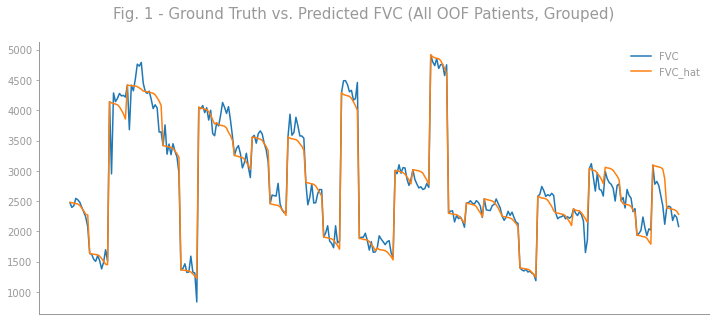

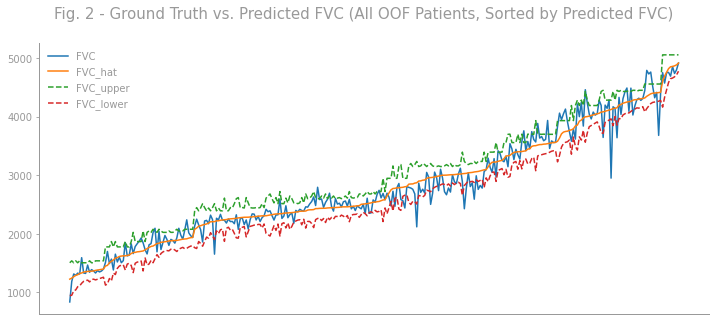

In [24]:
Q_cols = ['FVC', 'FVC_hat']

P_train = P.iloc[folds[FOLD_NUM]['train']]
P_val = P.iloc[folds[FOLD_NUM]['val']]

Y = P_val.copy()
MAE = mean_absolute_error(Y['FVC'], Y['FVC_hat'])

plt.figure(figsize=(12,5))
plt.suptitle('Fig. 1 - Ground Truth vs. Predicted FVC (All OOF Patients, Grouped)', fontsize=15)
for col in Q_cols:
    plt.plot(Y.reset_index().index, Y[col], label = col)
    plt.legend(loc='best', frameon = 0)
    plt.xticks([])
plt.show()

P_cols = ['FVC', 'FVC_hat', 'FVC_upper', 'FVC_lower']
Y_temp = Y.copy().sort_values(by='FVC_hat', ascending=True).reset_index(drop = True)
plt.figure(figsize=(12,5))
plt.suptitle('Fig. 2 - Ground Truth vs. Predicted FVC (All OOF Patients, Sorted by Predicted FVC)', 
             fontsize=15)
for c, col in enumerate(P_cols):
    if c<2: plt.plot(Y_temp.index, Y_temp[col], label = col)
    else: plt.plot(Y_temp.index, Y_temp[col], label = col, linestyle='--')
    plt.legend(loc='best', frameon = 0)
    plt.xticks([])
plt.show()

The above shows the ground truth (blue line) vs predicted FVC (gold line) values using the Linear Decay Model. The values in Fig. 1 are grouped by patient as it is in the data. Fig. 2 sorts the values by (increasing) predicted FVC and adds the upper and lower bounds of the prediction confidence as obtained by equation $(5)$. 

**Per-patient predictions**

FVC predictions, default and alternative sigma

In [25]:
val_patients = splits[FOLD_NUM].copy()
num_pats = len(val_patients)

Y['sigma2'] = Y.apply(lambda x: alt_sigma(x.Percent_init, x.coeff_pred, x.init_week), axis = 1)
Y['FVC_upper2'] = Y['FVC_hat'] + Y['sigma2']
Y['FVC_lower2'] = Y['FVC_hat'] - Y['sigma2']
P_cols2 = P_cols + ['FVC_upper2', 'FVC_lower2']
patient_split_idx = -1

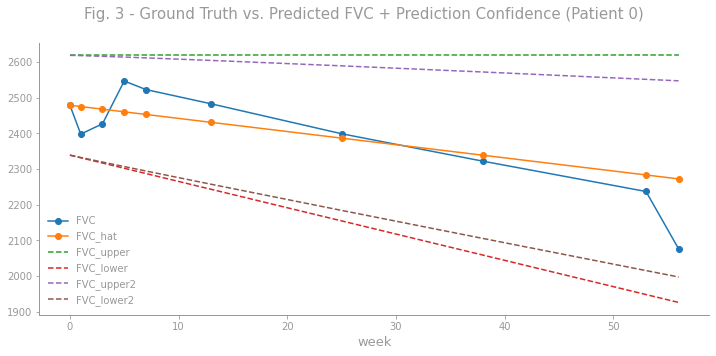

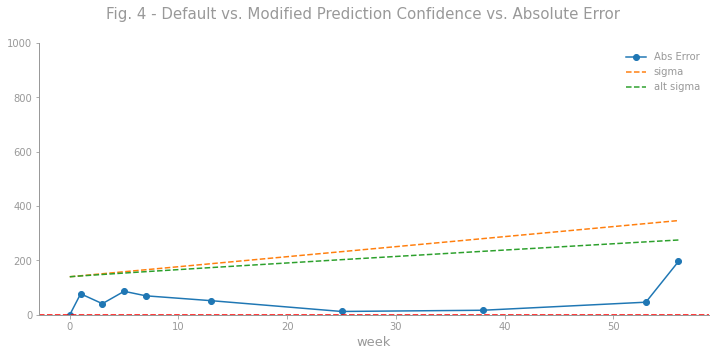

In [26]:
patient_split_idx += 1
if patient_split_idx > num_pats -1: patient_split_idx = 0
ex = Y[Y.Patient==val_patients[patient_split_idx]]

plt.figure(figsize=(12, 5))
plt.suptitle('Fig. 3 - Ground Truth vs. Predicted FVC + Prediction Confidence (Patient {})'.format(
    patient_split_idx), fontsize=15)
for c, col in enumerate(P_cols2):
    if c<2: plt.plot(ex.init_week, ex[col], marker='o', label = col)
    else: plt.plot(ex.init_week, ex[col], label = col, linestyle='--')
    plt.legend(loc='best', frameon = 0)
    plt.xlabel('week', fontsize=13)
plt.show()

plt.figure(figsize=(12,5))
plt.suptitle('Fig. 4 - Default vs. Modified Prediction Confidence vs. Absolute Error', fontsize=15)
plt.plot(ex.init_week, abs(ex['error']), marker='o', label = 'Abs Error')
plt.plot(ex.init_week, ex['sigma'], label = 'sigma', linestyle='--')
plt.plot(ex.init_week, ex['sigma2'], label = 'alt sigma', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='best', frameon = 0)
plt.ylim(0, 1000)
plt.xlabel('week', fontsize=13)
plt.show()

Fig. 3 Shows per patient ground-truth FVC (blue line) vs. predicted FVC (gold line) as obtained by the Linear Decay Model. The dotted green and red lines denote the upper and lower confidence prediction values (respectively) obtained by the sigma function using default $a$, $b$, and $c$ parameters. The dotted purple and brown lines denote the confidence values as obtained by the manual adjustments of the $a$, $b$, and $c$ parameters, chosen to optimize the Log Laplace Score as described above during post-processing.

Fig. 4 Plots the obtained default (gold dotted line) and modified (green dotted line) sigma values vs. the per-patient prediction absolute errors (blue line).

`patient_split_idx` allows to *loop* through all patients by simply re-running the cell.

**Aggregated Analysis**

Comparing week-aggregated (i.e. week averages, median, max or min) mean absolute error, fitted error, and confidence across patients. 

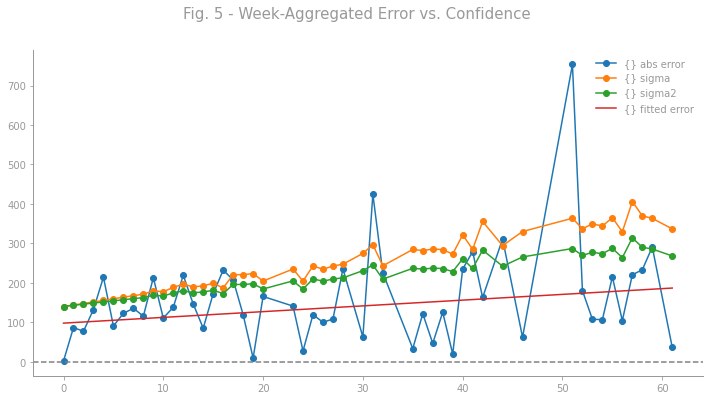

In [27]:
mean_week_error = pd.DataFrame(Y.groupby(['init_week'])['abs_error'].mean())
mean_week_sigma = pd.DataFrame(Y.groupby(['init_week'])['sigma'].mean())

mean_week_sigma2 = pd.DataFrame(Y.groupby(['init_week'])['sigma2'].mean())

weeks = Y['init_week']
error = Y['abs_error']
slope, intercept, _,_,_ = stats.linregress(weeks, error)
fitted_line = slope*weeks + intercept

Y['fitted'] = fitted_line
fitted = pd.DataFrame(Y.groupby(['init_week'])['fitted'].mean())

plt.figure(figsize=(12,6))
plt.suptitle('Fig. 5 - Week-Aggregated Error vs. Confidence', fontsize=15)
plt.plot(mean_week_error.index, mean_week_error['abs_error'], marker='o', label = '{} abs error')
plt.plot(mean_week_sigma.index, mean_week_sigma['sigma'], marker='o', label = '{} sigma')
plt.plot(mean_week_sigma.index, mean_week_sigma2['sigma2'], marker='o', label = '{} sigma2')
plt.plot(fitted.index, fitted['fitted'], label = '{} fitted error')
plt.legend(loc='best', frameon = 0)
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

Fig. 5 Shows aggregated measures of confidence versus aggregated measures of error. Although depicted here are the weekly means across patients, weekly median, min and max were also considered. 

The blue line corresponds to the aggregated absolute error, the gold line to the confidence with default $a$, $b$, and $c$ parameters, whereas the green line corresponds to the confidence with the optimized $a$, $b$, and $c$ parameters. The red line is the fitted absolute error line. 

Analysis of this graph was most useful while tuning the $a$, $b$, and $c$ parameters during post-processing, for adjusting these parameters so that the green line would be closer to the red line would generally improve the main performance metric i.e. equation $(1)$. 


# Quantile Regression

The other five ensemble components were trained using the Quantile Regression (QR) Model in this section, all trained using neural networks.

- The neural networks minimize a combination of the pinball loss (for multiple quantiles) and the modified Laplace Log Likelihood function in $(2)$. 
- Each component corresponds to one of the 5-folds created above.
- The input target variable are the FVC measurements.
- Features include scaled initial patient-specific variable values, and the time variable "`week`" which is a scaled version of the original variable "`Weeks`".

The output is a vector $\hat{y} = [\hat{y}^h, \hat{y}^m, \hat{y}^l]$, where $\hat{y}^l, \hat{y}^m, \hat{y}^h$ correspond, respectively, to the $q^l, q^m, q^h$ quantile predictions of the $FVC_{true}$. 

FVC predictions are then obtained by,
\begin{equation}
FVC_{predicted} = \hat{y}^m \tag{6}
\end{equation}

And the confidence $\sigma$ is obtained by,
\begin{equation}
\sigma = \hat{y}^h - \hat{y}^l \tag{7}
\end{equation}

$q^l, q^m, q^h$ were manually chosen to minimize $L_{dev}$ given by (2) in the various data subsets: i.e. within-fold ("train"), OOF ("valid"), and the last 3 measurements of the OOF subset.


### Dataset Pipeline

In [28]:
#@markdown Tensorflow Dataset API Pipeline QR Model
# if ran independently, this pipeline requires the get_dataset() function found
# in the Linear Decay "Dataset Pipeline" above.

def qr_input_arrays(fold_num, feats, datatype, augment_times, last3only = False):
    x = train[feats].iloc[folds[fold_num][datatype]] # x for all weeks
    x_3 = train[feats].iloc[folds_3[fold_num][datatype]] # x for the last 3 weeks
    y = train['FVC'].iloc[folds[fold_num][datatype]] # y for all weeks
    y_3 = train['FVC'].iloc[folds_3[fold_num][datatype]] # y for the last 3 weeks

    if last3only:
        x, y = x_3, y_3
    else:
        for n in range(augment_times):
            x = x.append(x_3)
            y = y.append(y_3)
    return np.array(x, dtype='float32'), np.array(y, dtype='float32')

def qr_datasets(fold_num,
                   feats, 
                   repeat_train = True,
                   shuffle_train = True,
                   augment_train = 2,
                   augment_val = 2, 
                   last3only = False,
                   batch_size = 128, 
                   buffer_size = 1240,
                   print_descr = True):

    x_train, y_train = qr_input_arrays(fold_num, feats, 'train', augment_train, last3only)
    buffer_size = x_train.shape[0]

    x_val, y_val = qr_input_arrays(fold_num, feats, 'val', augment_val, last3only)

    if batch_size == 'calc':
        # Note: arg batch_size applies only to train_dataset, valid will always use the 
        #       entire data. For evaluation, batch_size will use all data, also for train
        batch_size = x_train.shape[0]

    steps_per_epoch = np.ceil(x_train.shape[0]/batch_size).astype(int)
    input_shape = x_train.shape[1]

    train_dataset = get_dataset(x_train, y_train, batch_size, repeat = repeat_train, 
                                shuffle = shuffle_train, buffer_size = buffer_size)
    valid_dataset = get_dataset(x_val, y_val, batch_size = x_val.shape[0], cache = True)

    counts = [x_train.shape[0], x_val.shape[0]]

    if print_descr:
        describe_ds(train_dataset)
        describe_ds(valid_dataset)
        print('\nSteps per epoch: {} \nTrain examples: {} \nValid examples: {}\n'.format(steps_per_epoch, 
                                                                               counts[0], counts[1]))
        print('Input shape: {}\nBuffer size: {}'.format(input_shape, buffer_size))
        print('Batch size: {}\n'.format(batch_size))

    return train_dataset, valid_dataset, input_shape, steps_per_epoch, counts

### Loss, Evaluation Metric, and Validation Functions

In [29]:
#@markdown Quantile Loss for Multiple Quantiles, Log Laplace Score (Tensorflow Functions)
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype='float32')

def score(y_true, y_pred):
    '''
    Returns the Modified Log Laplace Likelihood Metric. 
    Tensorflow version to be used during training and evaluation.
    '''
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred, qs = [0.20, 0.50, 0.80]):
    '''
    Pinball loss for multi-quantile
    '''
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda, qs = [0.20, 0.50, 0.80]):
    '''
    Combines quantile loss with the Modified Log Laplace 
    Likelihood Metric
    '''
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred, qs) + (1 - _lambda)*score(y_true, y_pred) #+ _lambda*0.2*tf.keras.losses.MAE(y_true, y_pred)
    return loss
    

In [30]:
# @markdown Validation Analysis Functions (Quantile Regression)
 
def valid_analysis_df(model, FOLD_NUM):
    '''
    Makes predictions on the entire train dataset, processes
    the predictions, separates the subsets and performs 
    evaluation on the data subsets.
    Returns the prediction dataframes to be used for post-
    processing and Analysis.
    '''
    # Predictions on the entire dataset
    X = train[qr_features].copy()
    P = train[['Patient', 'Weeks', 'init_week', 'FVC']].copy()
    preds = model.predict(X)
    P['sig_lower'] = preds[:,0]
    P['FVC_hat'] = preds[:,1]
    P['sig_upper'] = preds[:,2]
    P['sigma'] = P['sig_upper'] - P['sig_lower']

    P['FVC_upper'] = P['FVC_hat'] + P['sigma']
    P['FVC_lower'] = P['FVC_hat'] - P['sigma']

    P['error'] = P['FVC'] - P['FVC_hat']
    P['abs_error'] = abs(P['error'])
    
    P_train = P.iloc[folds[FOLD_NUM]['train']].copy()
    P_val = P.iloc[folds[FOLD_NUM]['val']].copy()
    P_last3 = P.loc[folds_3[FOLD_NUM]['val']].copy()

    fvc_MAE = mean_absolute_error(P_val['FVC'], P_val['FVC_hat'])
    return P, P_train, P_val, P_last3, fvc_MAE

def full_eval(FOLD_NUM, model):
    '''
    Builds data subsets and performs evaluations to provide
    information at the end of training.  
    ''' 
    train_all, valid_all, _, _, _ = qr_datasets(
        fold_num = FOLD_NUM, 
        feats = qr_features,
        repeat_train = False,
        shuffle_train = False,
        augment_train = 0,
        augment_val = 0, 
        batch_size = 'calc',
        print_descr = False)

    train_3, valid_3, _, _, _ = qr_datasets(
        fold_num = FOLD_NUM, 
        feats = qr_features,
        repeat_train = False,
        shuffle_train = False,
        last3only = True,
        batch_size = 'calc',
        print_descr = False)
    
    dsets = ['train_all', 'train_3', 'valid_all', 'valid_3'] # strings to be able to use as keys, then use eval(string)
    eval_results = {}
    for ds in dsets:
        eval_results[ds] = model.evaluate(eval(ds), verbose=0)

    eval_dict = {}
    for k, v  in eval_results.items():
        spaces = 9 - len(k) # to make pretty print
        print('Score {}:{} {:.4f}'.format(k, ' '*spaces, v[1]))
        eval_dict[k] = round(v[1] , 4)
    return eval_dict

### Model

In [31]:
def qr_model(input_shape, dense_activations, dropout):
    inp = L.Input((input_shape,))

    x = L.Dense(dense_activations[0], activation='relu')(inp)
    if dropout[0]: x = L.Dropout(dropout[0])(x)
    if len(dense_activations) > 1:
        for i, a in enumerate(dense_activations[1:]):
            x = L.Dense(a, activation='relu')(x)
            if dropout[i+1]: x = L.Dropout(dropout[i+1])(x)

    p1 = L.Dense(3, activation='linear')(x) 
    p2 = L.Dense(3, activation='relu')(x)

    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1))([p1, p2])
    
    model = tf.keras.Model(inp, preds, name='Mult_Quant_Reg_F{}'.format(FOLD_NUM))
    return model

### Training

In [32]:
qr_features = ['fvc_init','week', 'sex_code', 'age', 'has_smoked', 'current_smoker', 'percent_init']

In [33]:
# TRAINING PARAMETERS
FOLD_NUM = 1
BATCH_SIZE = 256
EPOCHS = 2500

# MODELING PARAMETERS
LEARNING_RATE = 0.003
OPT = get_optimizer('Radam', LEARNING_RATE) 
m_lambda = 0.6
DENSE_SIZE = [128, 64]
dropout = [0., 0., 0., 0.]
dropout = dropout[:len(DENSE_SIZE)]
QS = [0.22, 0.5, 0.78]

# RECORDING 
fname = 'qr_model_fold_{}.h5'.format(FOLD_NUM)
checkpoint = config_checkpoint(fname, monitor = 'val_score')

# RETRIEVE CURRENT FOLD DATASETS
train_dataset, valid_dataset, input_shape, steps_per_epoch, counts = qr_datasets(
    fold_num = FOLD_NUM, 
    feats = qr_features,
    augment_train = 0, 
    augment_val = 1, 
    batch_size = BATCH_SIZE)

# BUILD AND COMPILE KERAS MODEL
K.clear_session()
with strategy.scope():
    model = qr_model(input_shape, DENSE_SIZE, dropout)
    model.compile(loss=mloss(m_lambda, QS), optimizer=OPT, metrics=[score])

# TRAIN MODEL
history = model.fit(train_dataset, 
                    steps_per_epoch = steps_per_epoch,
                    validation_data=valid_dataset, verbose = 0,
                    callbacks = [checkpoint],
                    epochs=EPOCHS)

# DISPLAY RESULTS
print('\nFull results LAST epoch:')
_ = full_eval(FOLD_NUM, model)

print('\nFull results BEST epoch:')
model = tf.keras.models.load_model(fname, compile=False)
model.compile(loss=mloss(m_lambda, QS), optimizer=OPT, metrics=[score])
scores_dict = full_eval(FOLD_NUM, model)
print('\n')

PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float32, tf.float32)
PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float32, tf.float32)

Steps per epoch: 5 
Train examples: 1234 
Valid examples: 413

Input shape: 7
Buffer size: 1234
Batch size: 256


Full results LAST epoch:
Score train_all: 6.7060
Score train_3:   7.0411
Score valid_all: 6.6141
Score valid_3:   6.8456

Full results BEST epoch:
Score train_all: 6.7159
Score train_3:   7.0670
Score valid_all: 6.5694
Score valid_3:   6.7367




In [34]:
print('Full results BEST epoch:')
scores_dict = full_eval(FOLD_NUM, model)

Full results BEST epoch:
Score train_all: 6.7159
Score train_3:   7.0670
Score valid_all: 6.5694
Score valid_3:   6.7367


### Prediction Analysis

**Ground Truth vs. Predicted FVC** <br>

All OOF predictions

Validation (all) MAE: 133.18
Dataframe shapes: (1234, 12) (308, 12) (105, 12)


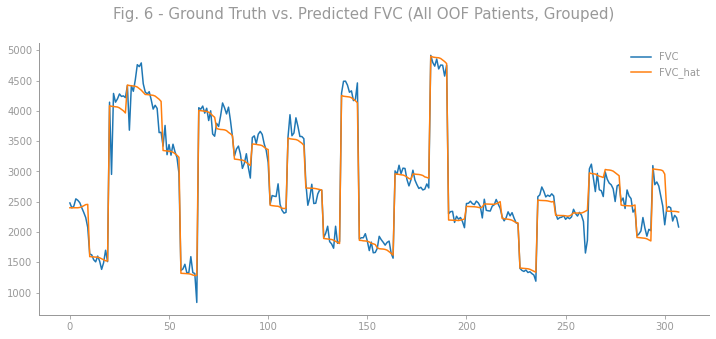

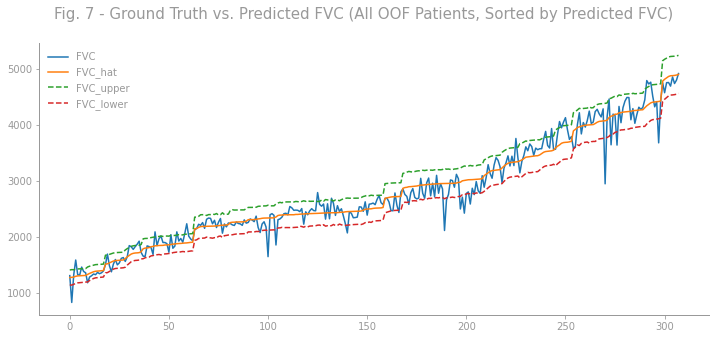

In [35]:
P, T, V, V3, val_mae = valid_analysis_df(model, FOLD_NUM)
print('Validation (all) MAE: {:.2f}'.format(val_mae))
print('Dataframe shapes:', *[x.shape for x in [T, V, V3]])

Y = V.copy()
plt.figure(figsize=(12,5))
plt.suptitle('Fig. 6 - Ground Truth vs. Predicted FVC (All OOF Patients, Grouped)', 
             fontsize=15)
for col in Q_cols:
    plt.plot(Y.reset_index().index, Y[col], label = col)
    plt.legend(loc='best', frameon = 0)
plt.show()

Y_temp = Y.copy().sort_values(by='FVC_hat', ascending=True).reset_index(drop = True)
plt.figure(figsize=(12,5))
plt.suptitle('Fig. 7 - Ground Truth vs. Predicted FVC (All OOF Patients, Sorted by Predicted FVC)', 
             fontsize=15)
for c, col in enumerate(P_cols):
    if c<2: plt.plot(Y_temp.index, Y_temp[col], label = col)
    else: plt.plot(Y_temp.index, Y_temp[col], label = col, linestyle='--')
    plt.legend(loc='best', frameon = 0)
plt.show()

The above shows the ground truth (blue line) vs predicted FVC (gold line) values using the Quantile Regression Model, the predicted values correspond to those as described in Equation $(6)$. The values in Fig. 6 are grouped by patient as it is in the data. Fig. 7 sorts the values by (increasing) predicted FVC and includes the upper and lower bounds of the prediction confidence. The upper and lower bounds are calculated as $FVC_{predicted} \pm \sigma$, where $\sigma$ is obtained as described in equation $(7)$.  

**Per-patient predictions**

In [36]:
patient_split_idx = -1
val_patients = splits[FOLD_NUM].copy()
assert val_patients.sort() == list(Y.copy().Patient.unique()).sort()
num_pats = len(val_patients)

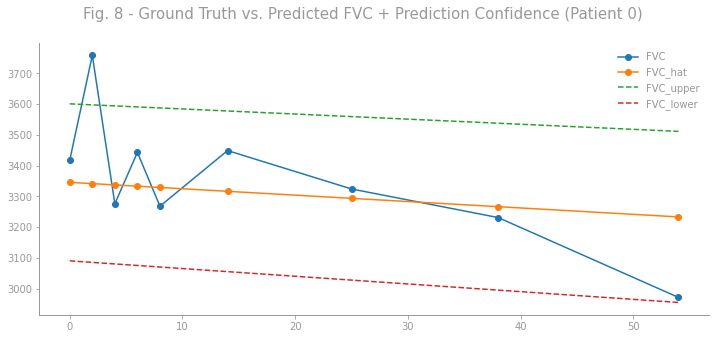

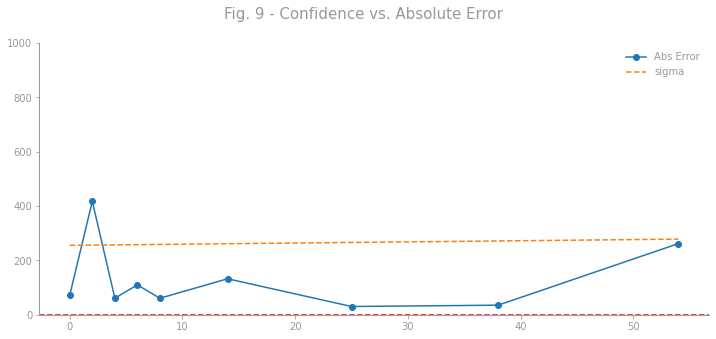

In [37]:
patient_split_idx += 1
if patient_split_idx > num_pats -1: patient_split_idx = 0
ex = Y[Y.Patient==val_patients[patient_split_idx]]

P_cols = ['FVC', 'FVC_hat', 'FVC_upper', 'FVC_lower']


plt.figure(figsize=(12, 5))
plt.suptitle('Fig. 8 - Ground Truth vs. Predicted FVC + Prediction Confidence (Patient {})'.format(
    patient_split_idx), fontsize=15)
for c, col in enumerate(P_cols):
    if c<2: plt.plot(ex.init_week, ex[col], marker='o', label = col)
    else: plt.plot(ex.init_week, ex[col], label = col, linestyle='--')
    plt.legend(loc='best', frameon = 0)
plt.show()


plt.figure(figsize=(12,5))
plt.suptitle('Fig. 9 - Confidence vs. Absolute Error', fontsize=15)
plt.plot(ex.init_week, abs(ex['error']), marker='o', label = 'Abs Error')
plt.plot(ex.init_week, ex['sigma'], label = 'sigma', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='best', frameon = 0)
plt.ylim(0, 1000)
plt.show()

Figs. 8 and 9 correspind to the Quantile Regression results and are analogous to Figs. 3 and 4 (respectively) for the linear decay predictions. Here however, confidence levels are not adjusted for post-process adjustments did not consistently improve results, all optimizations occur at training.

**Aggregated Analysis**

fold num: 1


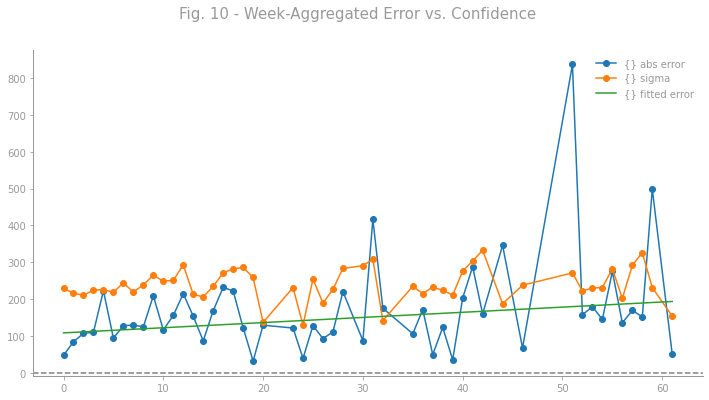

In [38]:
mean_week_error = pd.DataFrame(Y.groupby(['init_week'])['abs_error'].mean())
mean_week_sigma = pd.DataFrame(Y.groupby(['init_week'])['sigma'].mean())

weeks = Y['init_week']
error = Y['abs_error']
slope, intercept, _,_,_ = stats.linregress(weeks, error)
fitted_line = slope*weeks + intercept

Y['fitted'] = fitted_line
fitted = pd.DataFrame(Y.groupby(['init_week'])['fitted'].mean())

print('fold num:', FOLD_NUM)
plt.figure(figsize=(12,6))
plt.suptitle('Fig. 10 - Week-Aggregated Error vs. Confidence', fontsize=15)
plt.plot(mean_week_error.index, mean_week_error['abs_error'], marker='o', label = '{} abs error')
plt.plot(mean_week_sigma.index, mean_week_sigma['sigma'], marker='o', label = '{} sigma')
plt.plot(fitted.index, fitted['fitted'], label = '{} fitted error')
plt.legend(loc='best', frameon = 0)
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

Fig. 10 is analogous to Fig. 5 above. Here however, for the Quantile Regression case, analysis of this figure was most helpful at informing about the plausibility of the prediction layer in the neural network as well as that of the loss function. Specifically, the prediction layer and loss function were adjusted with to reflect the increased uncertainty with time. This however was met with mixed success, depending on the data. Generally, the Linear Decay Model was better at reproducing this feature. 

# Conclusion

The final ensemble consisted of ten components, five corresponding to neural networks trained on the 5-folds using Linear Decay Regression and the other five corresponding to neural networks trained on the 5-folds using Quantile Regression. All 10 components were chosen according to their performance on the entire train data but particular focus on the last three FVC measurements of patients in the OOF data subset. The metric being optimized was the Log Laplace Likelihood Metric in equation $(1)$, in which a value closer to $0$ is desirable. 

FVC predictions and confidence values resulting from all components were combined by calculating a simple average across all 10 predictions for FVC and $\sigma$ for each observation. This final step can be viewed in my final submission [here](https://www.kaggle.com/reyvaz/osic-linear-decay-and-quant-reg-inference).

Only patient metadata and FVC measurements were used during training and are necessary for inference. Features from CT-scans and other DICOM file metadata was discarded after failing to show improved predictive performance in various model specifications including CNN based neural networks. Judging from the performance of solutions submitted by other participants, it seems that such data as of yet, has not been able to successfully and significantly be used to improve predictive performance relative to the data used in this solution. 
